Initial setup

In [51]:
import wosis
import pandas as pd
import metaknowledge as mk
import json

In [52]:
# Helper functions for plotting
import wosis.analysis.plotting as wos_plot

# Analysis and search functions
from wosis.analysis import (preview_matches, search_records, keyword_matches, 
                            find_pubs_by_authors, preview_matches_by_keyword, get_unique_kw_titles,
                            remove_by_journals, remove_by_title)

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# This just helps make the plots look nicer
sns.set_style('darkgrid')
sns.set_context('paper', font_scale=2.0)

In [53]:
# Read in data from temporary cache file
query_id = "756d39801152fe5f5f4ad3a3df9b6a30"
RC = mk.RecordCollection("tmp/{}.txt".format(query_id))

#expected_num_records = 10694
#num_records = len(RC)

#assert num_records == expected_num_records, \
 #   "Mismatch in number of records - expected {}, got {}".format(expected_num_records, num_records)

print("Corpora consists of", num_records, "Publications")

Corpora consists of 15754 Publications


In [54]:
corpora_df = wosis.rec_to_df(RC)

corpora_df, removed_pubs = wosis.constrain.remove_empty_DOIs(corpora_df)

Removing 1799 records with no DOIs


In [55]:
# removed_pubs

In [56]:
# Checking if expected paper is in corpora
corpora_df.loc[corpora_df['DOI'] == '10.1016/j.jocs.2015.08.008', :]

,id,year,title,keywords,abstract,AU,SO,DE,DOI
13898,WOS:000367774700005,2015,Chaospy: An open source tool for designing met...,,the paper describes the philosophy design func...,"Feinberg, Jonathan|Langtangen, Hans Petter",JOURNAL OF COMPUTATIONAL SCIENCE,uncertainty quantification|polynomial chaos ex...,10.1016/j.jocs.2015.08.008


In [57]:
# Hiding keywords and abstract for tutorial (WoS-owned IP)
hide_columns = ['DE', 'abstract', 'keywords', 'DOI', 'id', 'kws']
corpora_df.loc[:, ~corpora_df.columns.isin(hide_columns)].head()  # display first 5

,year,title,AU,SO
0,2017,Correlated Parameters Uncertainty Propagation ...,"Razmkhah, Homa|AkhoundAli, Ali-Mohammad|Radman...",ENVIRONMENTAL MODELING & ASSESSMENT
1,2005,Parametric design sensitivity analysis of high...,"Dong, J|Choi, KK|Wang, AM|Zhang, WG|Vlahopoulo...",INTERNATIONAL JOURNAL FOR NUMERICAL METHODS IN...
2,2016,"Uncertainty analysis in 2,3,7,8-tetrachlorodib...","Dong, Zhaomin|Yuan, Guanxiang|Hu, Jianying",ENVIRONMENT INTERNATIONAL
3,2008,A recursive method for the F-policy G/M/1/K qu...,"Wang, Kuo-Hsiung|Kuo, Ching-Chang|Pearn, W. L.",APPLIED MATHEMATICAL MODELLING
4,2012,A comparison of eight metamodeling techniques ...,"Villa-Vialaneix, Nathalie|Follador, Marco|Ratt...",ENVIRONMENTAL MODELLING & SOFTWARE


In [58]:
# Create a new metaknowledge collection
filtered_corpora = wosis.extract_recs(corpora_df.loc[:, 'id'], RC, name='Filtered Corpora')

<hr>

Plot keyword trend

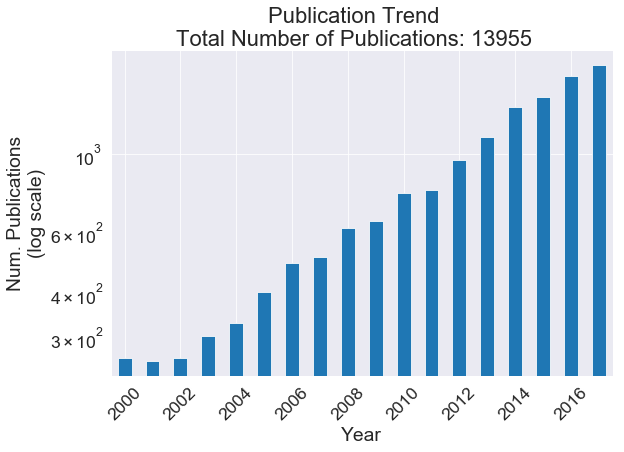

In [59]:
# Plot out the keyword trend. Can save the plot as an image if you give it a file location (will be saved in PNG format)
wos_plot.plot_pub_trend(filtered_corpora, title='Publication Trend', save_plot_fn=False)

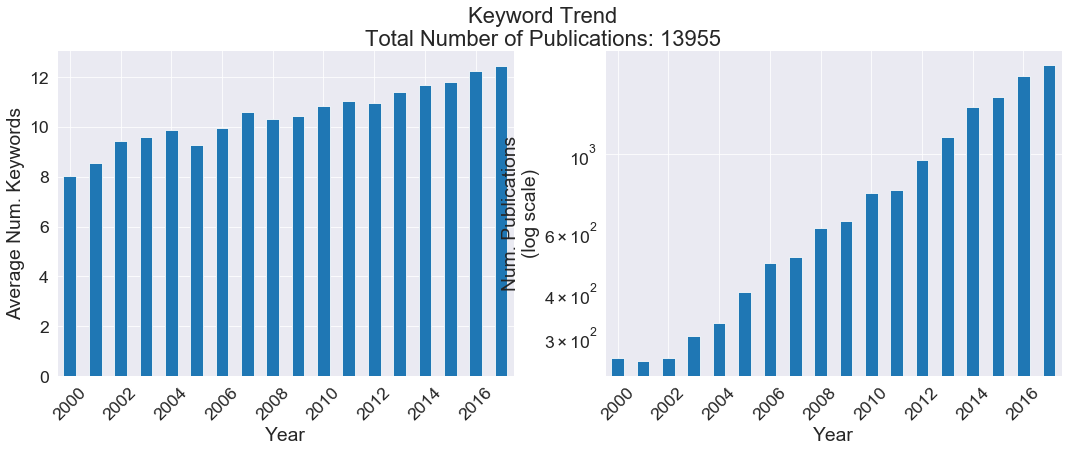

In [60]:
# Plot out the keyword trend. Can save the plot as an image if you give it a file location (will be saved in PNG format)
wos_plot.plot_kw_trend(filtered_corpora, title='Keyword Trend')

<hr>

Run topic model

In [61]:
from wosis.analysis import find_topics, get_topic_by_id

filtered_corpora_df = wosis.rec_to_df(filtered_corpora)
topic_model, trans, feature_names = find_topics(filtered_corpora_df, num_topics=5)

Topic 1: model water soil flow parameters sensitivity river data groundwater analysis
Topic 2: optimization design method shape topology sensitivity problem element finite analysis
Topic 3: energy cycle environmental life emissions production assessment waste impact lca
Topic 4: uncertainty model models stochastic data analysis method quantification parameter carlo
Topic 5: risk exposure assessment health cancer risks human flood probabilistic analysis


In [62]:
topic_pubs = {
    'model': get_topic_by_id(topic_model, trans, 1, filtered_corpora_df),
    # 'UA': get_topic_by_id(topic_model, trans, 8, filtered_corpora_df),
    # 'SA': get_topic_by_id(topic_model, trans, 20, filtered_corpora_df),    
}

# len(topic_pubs['model']), len(topic_pubs['UA'])
len(topic_pubs['model'])

5022

In [63]:
# find paper of interest - see if it's still in the corpora
for i in range(1,26):
    topic_set = get_topic_by_id(topic_model, trans, i, filtered_corpora_df)
    
    topic_recs = wosis.extract_recs(topic_set.loc[:, 'id'], RC, 'Topic of Interest')
    tmp_df = pd.DataFrame(topic_recs.forNLP(extraColumns=['DOI']))

    if len(tmp_df.loc[tmp_df["DOI"] == '10.1016/j.jocs.2015.08.008', :]) > 0:
        print("Found paper in topic", i)
        break

Found paper in topic 4


In [64]:
topic_set.loc[:, ~topic_set.columns.isin(hide_columns)].head(10)

,year,title,AU,SO
0,2017,Correlated Parameters Uncertainty Propagation ...,"Razmkhah, Homa|AkhoundAli, Ali-Mohammad|Radman...",ENVIRONMENTAL MODELING & ASSESSMENT
4,2012,A comparison of eight metamodeling techniques ...,"Villa-Vialaneix, Nathalie|Follador, Marco|Ratt...",ENVIRONMENTAL MODELLING & SOFTWARE
8,2012,Uncertainty and sensitivity analysis of coasta...,"de Moel, H.|Asselman, N. E. M.|Aerts, J. C. J. H.",NATURAL HAZARDS AND EARTH SYSTEM SCIENCES
13,2014,Uncertainty quantification for the impact of i...,"Bao, Jie|Chu, Yanjun|Xu, Zhijie|Tartakovsky, A...",INTERNATIONAL JOURNAL OF GREENHOUSE GAS CONTROL
14,2005,Minimizing uncertainty in vapour cloud explosi...,"Raman, R|Grillo, P",PROCESS SAFETY AND ENVIRONMENTAL PROTECTION
15,2004,Uncertainty assessment of the model RICEWQ in ...,"Miao, ZW|Trevisan, M|Capri, E|Padovani, L|Del ...",JOURNAL OF ENVIRONMENTAL QUALITY
25,2013,Variance Components and Generalized Sobol' Ind...,"Owen, Art B.",SIAM-ASA JOURNAL ON UNCERTAINTY QUANTIFICATION
27,2017,Remarks on multi-fidelity surrogates,"Park, Chanyoung|Haftka, Raphael T.|Kim, Nam H.",STRUCTURAL AND MULTIDISCIPLINARY OPTIMIZATION
29,2013,Uncertainty issues of a conceptual water balan...,"Li, Zhanling|Shao, Quanxi|Xu, Zongxue|Xu, Chon...",HYDROLOGICAL PROCESSES
30,2012,Ensemble-trained source apportionment of fine ...,"Balachandran, Sivaraman|Pachon, Jorge E.|Hu, Y...",ATMOSPHERIC ENVIRONMENT


In [65]:
topic_recs = wosis.extract_recs(topic_set.loc[:, 'id'], RC, 'Topic of Interest')

In [66]:
ua_topic_df = pd.DataFrame(topic_recs.forNLP(extraColumns=["DOI"]))

ua_topic_df.loc[ua_topic_df["DOI"] == '10.1016/j.jocs.2015.08.008', :]

,id,year,title,keywords,abstract,DOI
1640,WOS:000367774700005,2015,Chaospy: An open source tool for designing met...,,the paper describes the philosophy design func...,10.1016/j.jocs.2015.08.008


In [67]:
rec = RC.getID('WOS:000367774700005')
rec

<metaknowledge.WOSRecord object WOS:000367774700005>

<hr>

Plot journal trend of topic 1, see top publications by citation

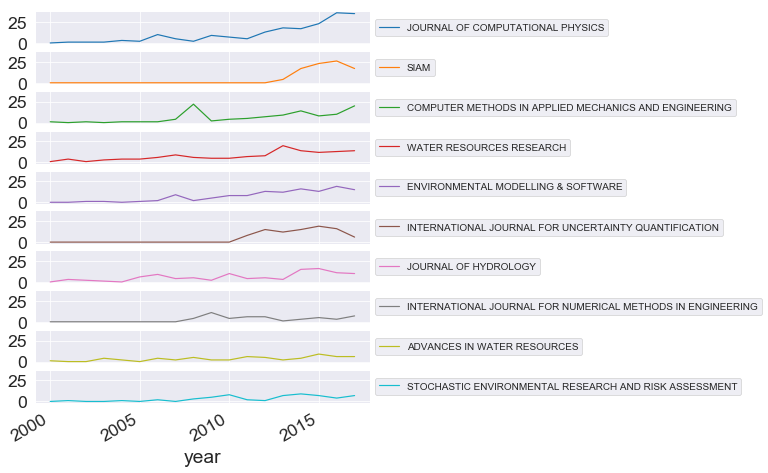

In [68]:
wos_plot.plot_journal_pub_trend(topic_recs)

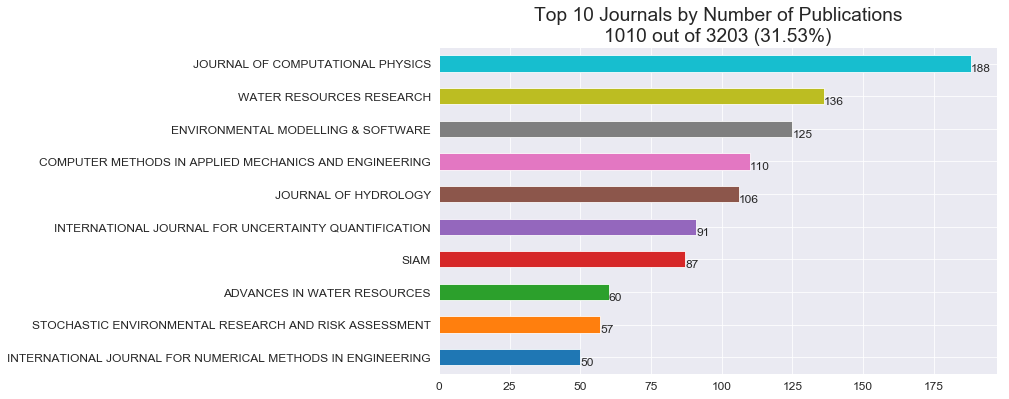

In [69]:
wos_plot.plot_pubs_per_journal(topic_recs, top_n=10, annotate=True, show_stats=True)

In [70]:
wosis.analysis.pub_citations(topic_recs)[0:50]
#ideas: could take first 1000 by citation number, but higher citations would favour older papers.  Taking by year?
#or simply choose first 1000 matches?

,Citations
Publication,
"Xiu, DB, 2005, High-order collocation methods for differential equations with random inputs, SIAM JOURNAL ON SCIENTIFIC COMPUTING, 27, 1118, 65700615",655
"Beven, K, 2001, Equifinality, data assimilation, and uncertainty estimation in mechanistic modelling of complex environmental systems using the GLUE methodology, JOURNAL OF HYDROLOGY, 249, 11, 279450",645
"Saltelli, A, 2002, Making best use of model evaluations to compute sensitivity indices, COMPUTER PHYSICS COMMUNICATIONS, 145, 280, 26483090",518
"Ghanem, R, 1991, Stochastic Finite Elements: A Spectral Approach, 277481739",467
"Saltelli, A., 2008, Global Sensitivity Analysis, The Primer, 287698885",304
"HELTON, JC, 1993, UNCERTAINTY AND SENSITIVITY ANALYSIS TECHNIQUES FOR USE IN PERFORMANCE ASSESSMENT FOR RADIOACTIVE-WASTE DISPOSAL, RELIABILITY ENGINEERING & SYSTEM SAFETY, 42, 327, 2602081",251
"Le Maitre, OP, 2004, Multi-resolution analysis of Wiener-type uncertainty propagation schemes, JOURNAL OF COMPUTATIONAL PHYSICS, 197, 502, 47398756",246
"Sobol, I. M., 1993, Sensitivity analysis for nonlinear mathematical models, Math. Model. Comput. Exp., 1, 407, 2602363",235
"Mckay, MD, 2000, A comparison of three methods for selecting values of input variables in the analysis of output from a computer code, TECHNOMETRICS, 42, 55, 13136551",216


In [71]:
topic_df = wosis.link_to_pub(topic_recs)  # Creates a new column called 'DOI link'
topic_df.loc[:, ~topic_df.columns.isin(hide_columns)].head(10)

,year,title,AU,SO,DOI link
0,2017,Correlated Parameters Uncertainty Propagation ...,"Razmkhah, Homa|AkhoundAli, Ali-Mohammad|Radman...",ENVIRONMENTAL MODELING & ASSESSMENT,https://dx.doi.org/10.1007/s10666-017-9569-z
1,2007,Relative importance of uncertain structural pa...,"Pradlwarter, H. J.",COMPUTATIONAL MECHANICS,https://dx.doi.org/10.1007/s00466-006-0127-9
2,2012,A comparison of eight metamodeling techniques ...,"Villa-Vialaneix, Nathalie|Follador, Marco|Ratt...",ENVIRONMENTAL MODELLING & SOFTWARE,https://dx.doi.org/10.1016/j.envsoft.2011.05.003
3,2015,Parallel tensor sampling in the hierarchical T...,"Grasedyck, Lars|Kriemann, Ronald|Loebbert, Chr...",COMPUTING AND VISUALIZATION IN SCIENCE,https://dx.doi.org/10.1007/s00791-015-0247-x
4,2016,Moving SWAT model calibration and uncertainty ...,"Zhang, Dejian|Chen, Xingwei|Yao, Huaxia|James,...",ENVIRONMENTAL MODELLING & SOFTWARE,https://dx.doi.org/10.1016/j.envsoft.2016.06.024
5,2012,Uncertainty and sensitivity analysis of coasta...,"de Moel, H.|Asselman, N. E. M.|Aerts, J. C. J. H.",NATURAL HAZARDS AND EARTH SYSTEM SCIENCES,https://dx.doi.org/10.5194/nhess-12-1045-2012
6,2014,Uncertainty quantification for the impact of i...,"Bao, Jie|Chu, Yanjun|Xu, Zhijie|Tartakovsky, A...",INTERNATIONAL JOURNAL OF GREENHOUSE GAS CONTROL,https://dx.doi.org/10.1016/j.ijggc.2013.10.023
7,2005,Minimizing uncertainty in vapour cloud explosi...,"Raman, R|Grillo, P",PROCESS SAFETY AND ENVIRONMENTAL PROTECTION,https://dx.doi.org/10.1205/psep.05028
8,2004,Uncertainty assessment of the model RICEWQ in ...,"Miao, ZW|Trevisan, M|Capri, E|Padovani, L|Del ...",JOURNAL OF ENVIRONMENTAL QUALITY,https://dx.doi.org/10.2134/jeq2004.2217
9,2014,Parametric sensitivity analysis for CO2 geoseq...,"Sarkarfarshi, Mirhamed|Malekzadeh, Farshad A.|...",INTERNATIONAL JOURNAL OF GREENHOUSE GAS CONTROL,https://dx.doi.org/10.1016/j.ijggc.2014.02.003


<hr>

Further analysis of topic model results: <br>
- Search papers in topic of interest by keyword
- Run criteria search on topic of interest
- Want to list these papers into a table to export to csv, this was formally achieved in an old notebook
- Plot trend in criteria matches
- Want to save the final plot to file, but it doesn't use the standard wos_plot function

In [72]:
# find papers of interest - having certain keywords

topic_set = get_topic_by_id(topic_model, trans, 2, filtered_corpora_df)

topic_recs = wosis.extract_recs(topic_set.loc[:, 'id'], RC, 'Topic of Interest')
# tmp_df = pd.DataFrame(topic_recs.forNLP(extraColumns=['DE']))
# need this next command to be keywords including ... eg uncertainty

tmp_df.loc[tmp_df["keywords"].str.contains("UNCERTAINTY"), :].head()
# some more ideas: filter topic 2 by papers with sensitivity in title/keywords/abstract to decrease size of dataset.
# might work for topic 1 as well?

,id,year,title,keywords,abstract,DOI
4,WOS:000385595200011,2016,Moving SWAT model calibration and uncertainty ...,RAINFALL-RUNOFF MODELS|WATER-QUALITY|PARAMETER...,with enhanced availability of high spatial res...,10.1016/j.envsoft.2016.06.024
11,WOS:000303094300009,2012,Model emulation and moment-independent sensiti...,UNCERTAINTY IMPORTANCE MEASURE|POLYNOMIAL CHAO...,momentindependent sensitivity methods are attr...,10.1016/j.envsoft.2011.06.006
17,WOS:000396233500009,2017,Calibration of the 1D shallow water equations:...,ADJOINT SENSITIVITY-ANALYSIS|OPEN-CHANNEL|ROUG...,the calibration of parameters in complex syste...,10.2166/hydro.2017.021
18,WOS:000293234900003,2011,The role of statistics in the analysis of ecos...,BAYESIAN NETWORK|MODELING APPROACH|DECISION-MA...,operationalising the holistic approach implici...,10.1002/env.1107
21,WOS:000407043700001,2017,Implications of Conceptual Channel Representat...,HYDRAULIC GEOMETRY RELATIONSHIPS|WATER ASSESSM...,hydrologic modeling outputs are influenced by ...,10.1111/1752-1688.12533


In [73]:
#want to see trend of global SA over years
#also should make a table of papers, see below
criteria = {
    'LSA': set(['local sensitivity analysis', 'LSA', 'local sensitivity']),
    'GSA': set(['global sensitivity analysis', 'GSA', 'global sensitivity']),
    'OAT': set(['one-at-a-time', 'OAT'])
}

crit_matches, crit_summary = wosis.keyword_matches_by_criteria(filtered_corpora, criteria, threshold=95.0)

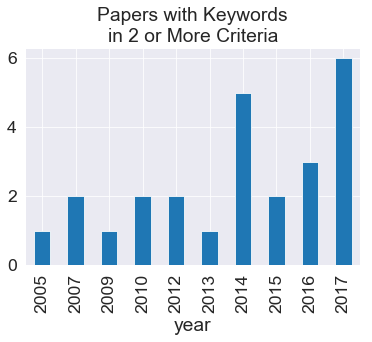

In [74]:
criteria_df = wosis.collate_keyword_criteria_matches(filtered_corpora, crit_matches)
wos_plot.plot_criteria_trend(criteria_df, threshold=2)

In [75]:
criteria_df.count()

id                    13955
year                  13955
title                 13955
keywords              13955
abstract              13955
num_criteria_match    13955
dtype: int64

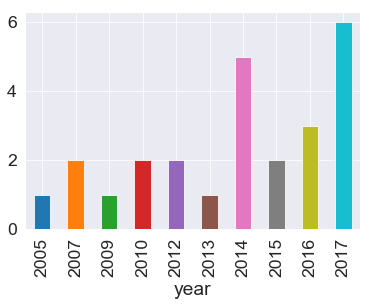

In [76]:
#want to view the papers in the above plot
crit_trend_tmp = criteria_df.loc[criteria_df['num_criteria_match'] > 1, ~criteria_df.columns.isin(hide_columns)]
#criteria_trend.loc[:, criteria_trend.columns.isin(hide_columns)].head(10)


crit_trend_tmp.groupby('year').count()['title'].plot(kind='bar')

In [77]:
crit_trend_tmp['title']

100            Making sense of global sensitivity analyses
519      SensSB: a software toolbox for the development...
1038     Necessary condition for applying experimental ...
1078     Assessing the robustness of adaptation decisio...
1783     Predicting the fate of micropollutants during ...
2311     Global sensitivity of structural variability b...
3042     Evaluating the Use of Global Sensitivity Analy...
3356     Sensitivity analysis of reference evapotranspi...
3888     Assessment of parametric uncertainty for groun...
4709     Global Sensitivity Analysis Techniques for Pro...
5387     Comparing global sensitivity analysis for a bi...
6584     Global Sensitivity-Based Model Updating for He...
7864     Modeling Nitrogen Dynamics in a Waste Stabiliz...
8112     The use of global sensitivity analysis for imp...
8630     A comparison between the uncertainties in mode...
8804     Distributed Evaluation of Local Sensitivity An...
8925     Parameter Sensitivity of a Surface Water Quali.

In [78]:
?wosis.keyword_matches

In [79]:
lsa_recs, lsa_summary = wosis.keyword_matches(filtered_corpora, criteria['LSA'], threshold=95.0)

In [80]:
from functools import reduce

In [81]:
lsa_collated = reduce(lambda x, y: x + y, list(lsa_recs.values()))

In [82]:
lsa_df = wosis.rec_to_df(lsa_collated)

In [83]:
gsa_recs, gsa_summary = wosis.keyword_matches(filtered_corpora, criteria['GSA'], threshold=95.0)
gsa_collated = reduce(lambda x, y: x + y, list(gsa_recs.values()))
gsa_df = wosis.rec_to_df(gsa_collated)

In [84]:
oat_recs, oat_summary = wosis.keyword_matches(filtered_corpora, criteria['OAT'], threshold=95.0)
oat_collated = reduce(lambda x, y: x + y, list(oat_recs.values()))
oat_df = wosis.rec_to_df(oat_collated)

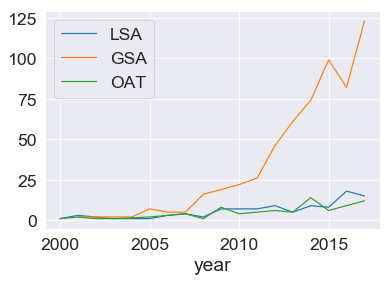

In [85]:
ax = lsa_df.groupby('year').count()['title'].plot(label="LSA", legend=True)
ax = gsa_df.groupby("year").count()['title'].plot(ax=ax, label="GSA", legend=True)
oat_df.groupby("year").count()['title'].plot(ax=ax, label="OAT", legend=True)